In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/scratch/anissa.el/MacroMicroNichesElMarrahi2022/data_analysis/notebooks/keren_building_blocks_analysis'

In [5]:
import numpy as np
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from src.CellAbundance import CellAbundance, join_abundance_matrices, generate_abundance_matrix
from src.utils.archetypes import ArchetypalAnalysis
from src.utils.visualization import plot_cumulative_explained_variance, plot_scatter_pca, plot_3Dscatter_pca, archetypes_bar_plot, archetype_simple_plot
from src.utils.equations import arch2color, alfa2rgb, scale, color_mapper
from src.Cell import group_map

In [6]:
CELL_TYPES = ['CD8-T', 'Other immune', 'DC / Mono', 'CD3-T', 'B', 'NK', 'Keratin-positive tumor', 'Tumor', 
              'CD4-T', 'Mesenchymal-like', 'Macrophages', 'Endothelial', 'Tregs', 'Unidentified', 'DC', 'Mono / Neu', 
              'Neutrophils']
#patient_ids = [1, 2, 3, 4, 5]
patient_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
N_SITE = 100
RADIUS = 25
ROOT_DATA_PATH = "../../data/cell_positions_data"

abs_log_ca_list = generate_abundance_matrix(CELL_TYPES, patient_ids, N_SITE, RADIUS, method='gaussian', snr=3, root=ROOT_DATA_PATH)
sites, patients_ids, s_ids, _ = join_abundance_matrices(abs_log_ca_list)
pca_3d = PCA()
pc3d = pca_3d.fit_transform(sites)

In [7]:
cellData = pd.read_csv("../../data/cellData.csv")
pixel2um_conversion = 0.39
cellData['cell_type'] = cellData.apply(lambda x: group_map(x.Group, x.immuneGroup), axis = 1)
size_pixel = cellData.groupby('cell_type')['cellSize'].mean() * pixel2um_conversion**2
a = np.array([size_pixel[x] for x in CELL_TYPES])
d = {x: size_pixel[x] for x in CELL_TYPES}

31415.926535897932


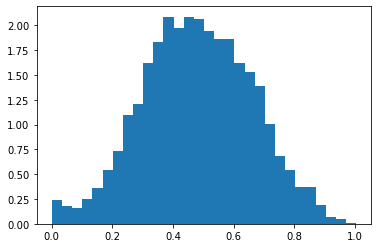

In [8]:
x = np.dot(a, sites.T)
print((100**2)*np.pi)
plt.hist(x, bins=30, density=True)
plt.show()

In [9]:
AA_3D = ArchetypalAnalysis(n_archetypes = 4, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
AA_3D.fit_transform(pc3d[:, :3])
def round2one(v):
    return v if v <= 1.0 else 1.0
color_map = np.array([[255, 0, 0], [0, 153, 51], [0, 0, 255], [255, 255, 0]]).T
sites_archetype = [np.array([round2one(x) for x in color_mapper(color_map, c)/255]) for c in AA_3D.alfa.T]

In [10]:
n_components = 3
n_of_std = 1.5
X = pc3d
V = pca_3d.components_.T

In [11]:
std_vx_last = np.matmul(V[:, n_components:], X.T[n_components:,:]).std(axis=1)
std_vx_last

array([5.16759734e-04, 4.97418856e-04, 3.19161136e-04, 2.58488799e-04,
       2.76119749e-04, 9.29462831e-05, 1.27507511e-04, 3.74549829e-04,
       5.02980715e-04, 5.06948353e-04, 7.92380236e-04, 2.00409885e-04,
       1.37685005e-04, 1.54123394e-04, 2.81772788e-04, 2.37389457e-04,
       4.61887559e-04])

In [12]:
std_vx = np.matmul(V, X.T).std(axis=1)
std_vx_last / std_vx 

array([0.51087812, 0.91710365, 0.88758213, 0.90547694, 0.17428097,
       0.89070822, 0.04991573, 0.98824598, 0.41272284, 0.89870528,
       0.82864486, 0.95750517, 0.93319697, 0.95730357, 0.98820663,
       0.98055215, 0.99692962])

In [13]:
std_vx_area = np.dot(a, np.matmul(V[:, n_components:], X.T[n_components:,:])).std()
std_vx_area

0.09898457664572295

In [14]:
site_area = (100**2)*np.pi
# first constraints
A = -V[:, :3]
b = -np.mean(sites, axis=0)-n_of_std*std_vx_last
# second constraint
A_bis = np.dot(a, V[:, :n_components])
b_bis = np.dot(a.T, np.mean(sites, axis=0)) - site_area - n_of_std*std_vx_area

In [15]:
b_bis

-31415.59521166982

In [16]:
a, pca_3d.components_[:3, :].T

(array([53.94091087, 59.9724407 , 60.70578349, 55.2961969 , 49.0715331 ,
        51.99946958, 78.79665779, 55.41773314, 48.93100883, 58.47756178,
        61.19078508, 63.44055323, 66.76588859, 52.09470489, 58.31931529,
        56.55593958, 59.16649709]),
 array([[-0.13591067, -0.00471926,  0.64225027],
        [-0.06988762, -0.06554254,  0.00162525],
        [-0.04824076, -0.00525377,  0.08299027],
        [-0.03627348, -0.01062548,  0.05633015],
        [-0.21909559,  0.87306376, -0.27940107],
        [-0.00863204,  0.00446662,  0.03314646],
        [ 0.92708874,  0.25700834,  0.2030237 ],
        [ 0.00406944, -0.01577482, -0.04150563],
        [-0.21076807,  0.36865874,  0.60833957],
        [-0.05235699, -0.07920517, -0.12884755],
        [-0.13146659, -0.15320809,  0.25739701],
        [-0.0209545 , -0.01299144,  0.0012493 ],
        [-0.00574609, -0.00102332,  0.04129041],
        [-0.00901114, -0.01617413, -0.02442647],
        [-0.01526389,  0.00850118,  0.00350998],
        [-

In [17]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog
# [A; b]
halfspaces = np.vstack((np.c_[A,b], np.append(A_bis, b_bis))).astype('double')
print(halfspaces)
#c = np.zeros((halfspaces.shape[1]-1,))
#A_lin = halfspaces[:, :-1]
#b_lin = - halfspaces[:, -1]
#print(c.shape)
#res = linprog(c, A_ub=A_lin, b_ub=b_lin, bounds=(None, None))
feasible_point = np.array([0, 0, 0]).astype('double')
hs = HalfspaceIntersection(halfspaces, feasible_point)

[[ 1.35910670e-01  4.71926093e-03 -6.42250271e-01 -1.31825602e-03]
 [ 6.98876178e-02  6.55425433e-02 -1.62525379e-03 -9.61448434e-04]
 [ 4.82407595e-02  5.25377444e-03 -8.29902738e-02 -6.48677998e-04]
 [ 3.62734786e-02  1.06254760e-02 -5.63301458e-02 -5.18488096e-04]
 [ 2.19095594e-01 -8.73063764e-01  2.79401074e-01 -7.51295779e-04]
 [ 8.63204401e-03 -4.46662131e-03 -3.31464616e-02 -1.62011530e-04]
 [-9.27088736e-01 -2.57008340e-01 -2.03023704e-01 -3.83402232e-03]
 [-4.06944266e-03  1.57748162e-02  4.15056280e-02 -6.73580050e-04]
 [ 2.10768072e-01 -3.68658743e-01 -6.08339570e-01 -1.20243535e-03]
 [ 5.23569906e-02  7.92051709e-02  1.28847551e-01 -1.05095532e-03]
 [ 1.31466590e-01  1.53208089e-01 -2.57397008e-01 -1.92070737e-03]
 [ 2.09545042e-02  1.29914368e-02 -1.24930374e-03 -3.77386705e-04]
 [ 5.74609038e-03  1.02332078e-03 -4.12904082e-02 -2.55266596e-04]
 [ 9.01114405e-03  1.61741291e-02  2.44264739e-02 -2.86653825e-04]
 [ 1.52638949e-02 -8.50117925e-03 -3.50997603e-03 -4.58727746e

0.82% Total Exp. Var.


<IPython.core.display.Javascript object>


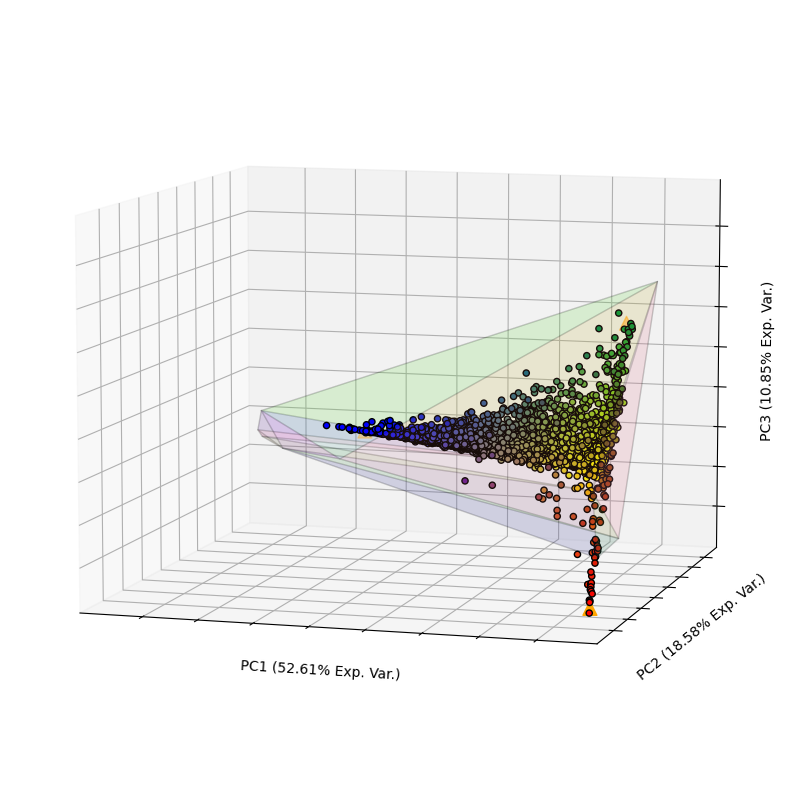

In [18]:
%matplotlib notebook
plt = plot_3Dscatter_pca(pc3d, pca_3d.explained_variance_ratio_, labels=sites_archetype, archetypes=AA_3D.archetypes, halfspaces=(hs, A_bis, b_bis))
#plt.savefig("../../../output/grants_images/3d_gaussian_boudaries_plot.svg")
plt.show()

<IPython.core.display.Javascript object>


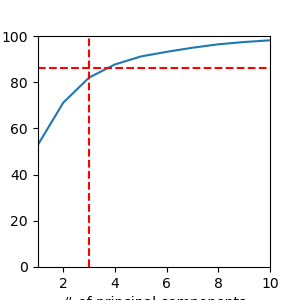

In [19]:
plt = plot_cumulative_explained_variance(pca_3d.explained_variance_ratio_)
#plt.savefig("../../../output/grants_images/cumulative_variance_exp_plot.svg")
plt.show()

In [ ]:
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

hs = HalfspaceIntersection(halfspaces, res.x)
verts = hs.intersections
hull = ConvexHull(verts)
faces = hull.simplices

ax = a3.Axes3D(plt.figure())
ax.dist=10
ax.azim=30
ax.elev=10
ax.set_xlim([-200,200])
ax.set_ylim([-200,200])
ax.set_zlim([-200,200])

for s in faces:
    sq = [
        [verts[s[0], 0], verts[s[0], 1], verts[s[0], 2]],
        [verts[s[1], 0], verts[s[1], 1], verts[s[1], 2]],
        [verts[s[2], 0], verts[s[2], 1], verts[s[2], 2]]
    ]

    f = a3.art3d.Poly3DCollection([sq])
    f.set_color(colors.rgb2hex(np.random.rand(3)))
    f.set_edgecolor('k')
    f.set_alpha(0.1)
    ax.add_collection3d(f)

plt.show()